In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import zeros, newaxis
from sklearn.preprocessing import MinMaxScaler

import tensorflow.keras
from common.data_loader import *
from common.preprocessing import * 
from common.util import set_random_seed
from tensorflow.keras import Input
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU,Conv1D ,Dropout,Conv1DTranspose, Bidirectional, TimeDistributed,RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from datetime import datetime
from os import path, environ
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt
from pytz import timezone


environ["CUDA_VISIBLE_DEVICES"] = "0"
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)


2022-07-29 14:12:01.528593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 14:12:01.535745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 14:12:01.535997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
SEQ_LEN = 2
BATCH_SIZE = 256
EPOCHS = 10

In [4]:
# Load dataset
full_data = pd.read_csv("data/data5_gi.csv")
submission = pd.read_csv("data/sample_submission.csv")
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4228623 entries, 0 to 4228622
Data columns (total 15 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
 13  Date     object 
 14  Time     int64  
dtypes: float64(10), int64(3), object(2)
memory usage: 483.9+ MB


In [6]:
full_data = marking_data(full_data, 0)
full_data = feature_engineering(full_data, compute_Pmax_method ='clipping', compute_Pmax_clipping=False)

* Data name: Feature engineering
  - Number of data: 4228623
  - Number of nan rows: 864


### best feature score 170

In [6]:
# ## n to n multivariant prediction
# features = ['TurbID','Day','RPM', 'Bspd1', 'Bspd3', 'Bspd2', 'WspdX', 'Wspd', 'Wspd_cube', 'Pmax', 'Pab1', 'Pab2', 'Pab3', 'TSR1', 'TSR2', 'TSR3', 'Prtv','Patv']
# full_data_selectd = full_data[features]

In [7]:
## Wspd univariant prediction then calculate patv
features = ['TurbID','Day','Tmstamp','Wspd']
full_data_selectd = full_data[features]

In [8]:
data = full_data_selectd[(full_data_selectd['Day']>=1)&(full_data_selectd['Day']<=222)]

In [9]:
day = 144
hour = 6
ten_minute = 1
train_x, train_y, val_x, val_y,test_x = make_train_val_test_data(data, in_seq_len=SEQ_LEN*144, out_seq_len=SEQ_LEN*144, stride=day, shuffle=False, test_size=0.05)

100%|██████████| 134/134 [00:13<00:00, 10.07it/s]


* Data Split
  - Train data(X, y)     : (24998, 288, 1) (24998, 288, 1)
  - Validation data(X, y): (1337, 288, 1) (1337, 288, 1)
  - Test data(X)         : (134, 288, 1)


In [10]:
## only for multivariant
scaler = MinMaxScaler()
scaler.fit(train_x.reshape(-1,train_x.shape[2]))
train_x = scaler.transform(train_x.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
train_y= scaler.transform(train_y.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
val_x = scaler.transform(val_x.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
val_y = scaler.transform(val_y.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
test_x = scaler.transform(test_x.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
print("Train data(X, y):", train_x.shape, train_y.shape)
print("Validation data(X, y):", val_x.shape, val_y.shape)
print("Test data(X):", test_x.shape)

Train data(X, y): (24998, 288, 1) (24998, 288, 1)
Validation data(X, y): (1337, 288, 1) (1337, 288, 1)
Test data(X): (134, 288, 1)


In [11]:
## only for multivariant
output_shape = 1
train_y = train_y[:,:,-output_shape:].reshape(-1,train_x.shape[1],output_shape)
val_y = val_y[:,:,-output_shape:].reshape(-1,train_x.shape[1],output_shape)

In [12]:
# Generate dataset
train_ds = generate_dataset(train_x, train_y, batch_size=BATCH_SIZE)
test_ds = generate_dataset(val_x, val_y, batch_size=BATCH_SIZE)

2022-07-29 14:13:06.742636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-29 14:13:06.743500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 14:13:06.743846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 14:13:06.743998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [13]:
set_random_seed(32)

model = Sequential(name="GRU-Model") # Model
model.add(Input(shape=(train_x[0].shape[0],train_x[0].shape[1]), name='Input-Layer')) 
model.add(Bidirectional(GRU(units=256, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-GRU-Encoder-Layer')) # Encoder Layer
model.add(RepeatVector(train_y[0].shape[0], name='Repeat-Vector-Layer')) # Repeat Vector
model.add(Bidirectional(GRU(units=256, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer1')) # Decoder Layer
model.add(TimeDistributed(Dense(units=train_y[0].shape[1], activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x

In [14]:
model.summary()

Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-GRU-Encoder-Layer (B  (None, 512)              397824    
 idirectional)                                                   
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 288, 512)         0         
 Vector)                                                         
                                                                 
 Hidden-GRU-Decoder-Layer1 (  (None, 288, 512)         1182720   
 Bidirectional)                                                  
                                                                 
 Output-Layer (TimeDistribut  (None, 288, 1)           513       
 ed)                                                             
                                                                 
Total params: 1,581,057
Trainable params: 1,581,057
Non-t

In [15]:
##### Step 4 - Compile the model
model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError', 'MeanAbsoluteError'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
              loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
              weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
              run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
              steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
             )

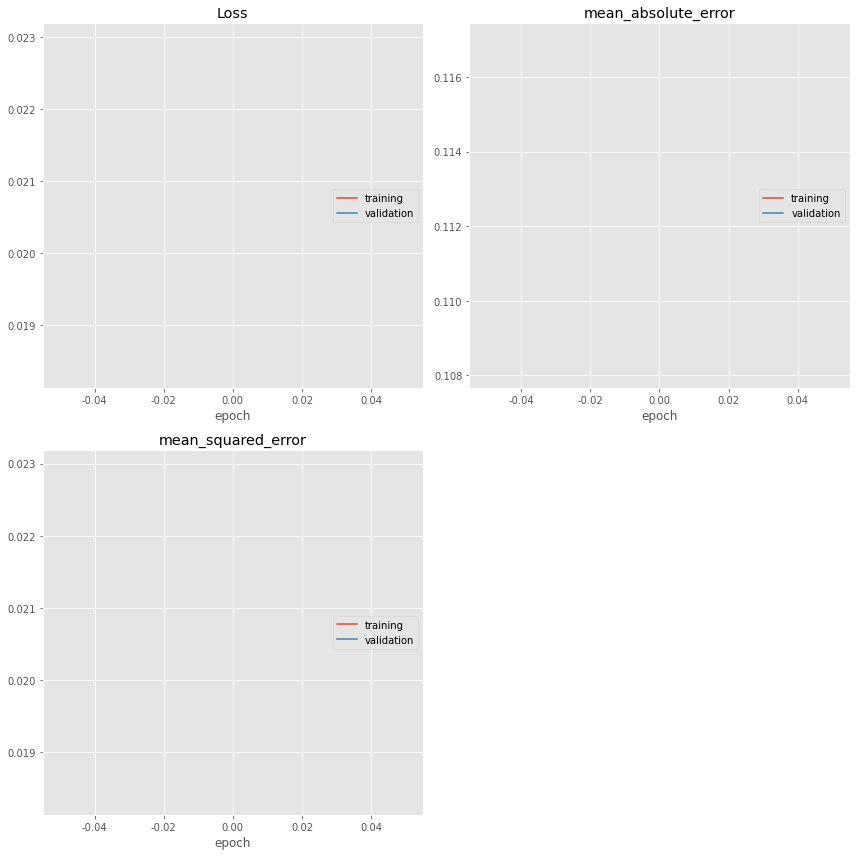

Loss
	training         	 (min:    0.018, max:    0.018, cur:    0.018)
	validation       	 (min:    0.023, max:    0.023, cur:    0.023)
mean_absolute_error
	training         	 (min:    0.108, max:    0.108, cur:    0.108)
	validation       	 (min:    0.117, max:    0.117, cur:    0.117)
mean_squared_error
	training         	 (min:    0.018, max:    0.018, cur:    0.018)
	validation       	 (min:    0.023, max:    0.023, cur:    0.023)
98/98 [==============================] - 15s 92ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - mean_absolute_error: 0.1081 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1170
-------------------- Evaluation on Test Data --------------------


INFO:tensorflow:Assets written to: saved_models/model_ep10_b256_seq2_2022-07-29 23:13:44/assets


INFO:tensorflow:Assets written to: saved_models/model_ep10_b256_seq2_2022-07-29 23:13:44/assets


In [16]:
##### Step 5 - Fit the model on the dataset
history = model.fit(train_ds, # input data, # target data
                    batch_size=1, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
                    epochs=1, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
                    verbose=1, # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
                    callbacks=[ PlotLossesKeras()
                              ], # default=None, list of callbacks to apply during training. See tf.keras.callbacks
                    #validation_split=0.2, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. 
                    validation_data=test_ds, # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch. 
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
                    sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
                    initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
                    steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
                    validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
                    validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
                    validation_freq=1, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
                    max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
                    workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
                    use_multiprocessing=True, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
                   )

print('-------------------- Evaluation on Test Data --------------------')

os.makedirs('saved_models')
now = datetime.now(timezone('Asia/Seoul'))
current_time = now.strftime('%Y-%m-%d %H:%M:%S')
model.save(f'saved_models/model_ep{EPOCHS}_b{BATCH_SIZE}_seq{SEQ_LEN}_{current_time}')

In [17]:
output_shape = 1

In [18]:
y_pred = model.predict(test_x)
y_pred = y_pred.reshape(-1, y_pred.shape[2])
y_pred = np.pad(y_pred, ((0,0),(test_x.shape[2]-output_shape,0)))
# y_pred = scaler.inverse_transform(y_pred)
wspd = y_pred[:,-1]
target = np.clip(wspd**3/300*807*0.2,0,1500)
submission['Patv'] =target
now = datetime.now(timezone('Asia/Seoul'))
current_time = now.strftime('%Y-%m-%d %H:%M:%S')
submission.to_csv(f"transformer_prediction_{current_time}.csv", index=False)

5/5 [==============================] - 1s 24ms/step
